In [1]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
%pip install -qr requirements.txt  # install dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import shutil 
import xml.etree.ElementTree as ET


from pathlib import Path
from shutil import copyfile, move
from IPython.display import Image, clear_output  
from google.colab import drive

clear_output()
drive.mount('./gdrive')

!nvidia-smi

Mounted at ./gdrive
Sun Sep 12 16:43:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                    

In [2]:
!mkdir dataset
!mkdir dataset/labels
!mkdir dataset/val
!mkdir dataset/val/images
!mkdir dataset/val/labels
shutil.unpack_archive('/content/yolov5/gdrive/MyDrive/sber/data/annotations.zip', './dataset/')
shutil.unpack_archive('/content/yolov5/gdrive/MyDrive/sber/data/images.zip', './dataset/')

In [ ]:
#rm -rf dataset

In [3]:
!python -V

Python 3.7.11


### Рассмотрение содержимого аннонтаций к данным

In [4]:
annotation_dir = Path('/content/yolov5/dataset/annotations')

In [5]:
bb_path = './object/bndbox/'
size_path = './size/'
data = {
    'width': [],
    'height': [],
    'depth': [],
    'bb_amount': [],
    'pose': [],
    'segmented': [],
    'occluded': [],
    'difficult': [],
    'truncated': [], 
    'name': []
    }

for file in annotation_dir.glob('*.xml'):
    tree_root = ET.parse(file).getroot()

    # for el in tree_root.findall(bb_path):
    #     data[el.tag].append(int(el.text))
    
    segmented = int(tree_root[3].text)
    truncated = int(tree_root[4][2].text)
    occluded = int(tree_root[4][3].text )
    difficult = int(tree_root[4][4].text)
    pose = tree_root[4][1].text
    name = tree_root[1].text

    data['bb_amount'].append(len(tree_root.findall(bb_path))//4)
    data['pose'].append(pose)
    data['segmented'].append(segmented)
    data['occluded'].append(occluded)
    data['difficult'].append(difficult)
    data['truncated'].append(truncated)
    data['name'].append(name)

    for el in tree_root.findall(size_path):
        data[el.tag].append(int(el.text))

data = pd.DataFrame(data)
data

width  height  depth  ...  difficult truncated         name
0      400     242      3  ...          0         0  Cars151.png
1      400     267      3  ...          0         0  Cars341.png
2      400     319      3  ...          0         0   Cars94.png
3      400     225      3  ...          0         0  Cars184.png
4      400     267      3  ...          0         0  Cars109.png
..     ...     ...    ...  ...        ...       ...          ...
428    400     255      3  ...          0         0  Cars329.png
429    400     225      3  ...          0         0  Cars323.png
430    555     416      3  ...          0         0  Cars394.png
431    400     225      3  ...          0         0  Cars309.png
432    400     225      3  ...          0         0  Cars247.png

[433 rows x 10 columns]

In [6]:
for key in data.keys():
    print(key,len(data[key]))

width 433
height 433
depth 433
bb_amount 433
pose 433
segmented 433
occluded 433
difficult 433
truncated 433
name 433


In [7]:
for col in data.columns[2:-1]:
    print(col, *data[col].unique())

depth 3
bb_amount 1 2 4 6
pose Unspecified
segmented 0
occluded 0
difficult 0
truncated 0


In [ ]:
data.describe()

width      height  depth  ...  occluded  difficult  truncated
count  433.000000  433.000000  433.0  ...     433.0      433.0      433.0
mean   425.113164  292.138568    3.0  ...       0.0        0.0        0.0
std     68.180545   66.462460    0.0  ...       0.0        0.0        0.0
min    225.000000  141.000000    3.0  ...       0.0        0.0        0.0
25%    400.000000  246.000000    3.0  ...       0.0        0.0        0.0
50%    400.000000  270.000000    3.0  ...       0.0        0.0        0.0
75%    400.000000  307.000000    3.0  ...       0.0        0.0        0.0
max    600.000000  531.000000    3.0  ...       0.0        0.0        0.0

[8 rows x 8 columns]

### На основании анализа выяснено, что:

*   На картинках бывает от 1 до 6 боксов с номерам, но зачастую он один
*   Никаких других отличий, отмеченных в xml не найдено

Также мной были просмотрены все картинки вручную, и было принято решение разбивать выборку случайным образом, тк не было выявлено каких либо причин этого не делать :)

### **В следующих ячейках будет произведена обработка данных для приведения их к формату, необходимому для дообучения модели детекции.**

#### В качестве модели детекции была выбрана yolov5 от ultralytics, выбрал ее так как уже имел опыт работы с ней, и она показала хороший результат. А в условиях сильно ограничения по времени это, как мне кажется, оптимальный выбор. 

In [8]:
labels_dir = Path('./dataset/labels')
for file in annotation_dir.glob('*.xml'):
    tree_root = ET.parse(file).getroot()
    img_shape = {
        'width': 1,
        'height': 1,
        'channels': 3
    }
    bb_data = {
        'xmin': [],
        'xmax': [],
        'ymin': [],
        'ymax':[],
    }

    for el in tree_root.findall(size_path):
        img_shape[el.tag] = int(el.text)

    for el in tree_root.findall(bb_path):
        bb_data[el.tag].append(int(el.text))

    bb_data['label'] = [0] * len(bb_data['xmin'])
    bb_data = pd.DataFrame(bb_data)
    bb_data['xc'] = (bb_data['xmax'] + bb_data['xmin']) / (2 * img_shape['width'])
    bb_data['yc'] = (bb_data['ymax'] + bb_data['ymin']) / (2 * img_shape['height'])
    bb_data['width'] = (bb_data['xmax'] - bb_data['xmin']) / img_shape['width']
    bb_data['height'] = (bb_data['ymax'] - bb_data['ymin']) / img_shape['height']
    bb_data[['label', 'xc', 'yc', 'width', 'height']].to_csv(labels_dir / (file.stem + '.txt'),' ', header=None, index=False)

In [9]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data.name.values, test_size=0.2, random_state=142)

src_dir = Path('/content/yolov5/dataset/images')
dist_dir = Path('dataset/val/images')
labels_srcdir = Path('/content/yolov5/dataset/labels')
labels_distdir = Path('dataset/val/labels/')

for image_name in test:
    move(src_dir / image_name, dist_dir / image_name)
    move(labels_srcdir / (image_name[:-3] + 'txt'), labels_distdir / (image_name[:-3] + 'txt'))

In [10]:
%pip install -q wandb
import wandb
wandb.login()

     |████████████████████████████████| 1.7 MB 7.0 MB/s 
     |████████████████████████████████| 133 kB 82.4 MB/s 
     |████████████████████████████████| 170 kB 98.8 MB/s 
     |████████████████████████████████| 97 kB 8.5 MB/s 
     |████████████████████████████████| 63 kB 2.4 MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

**Были опробованы модели разных размеров и на основании баланса между скоростью работы и размером модели выбор пал на среднюю модель.**

Результаты моделей различных размеров: 
<p>Маленькая</p>

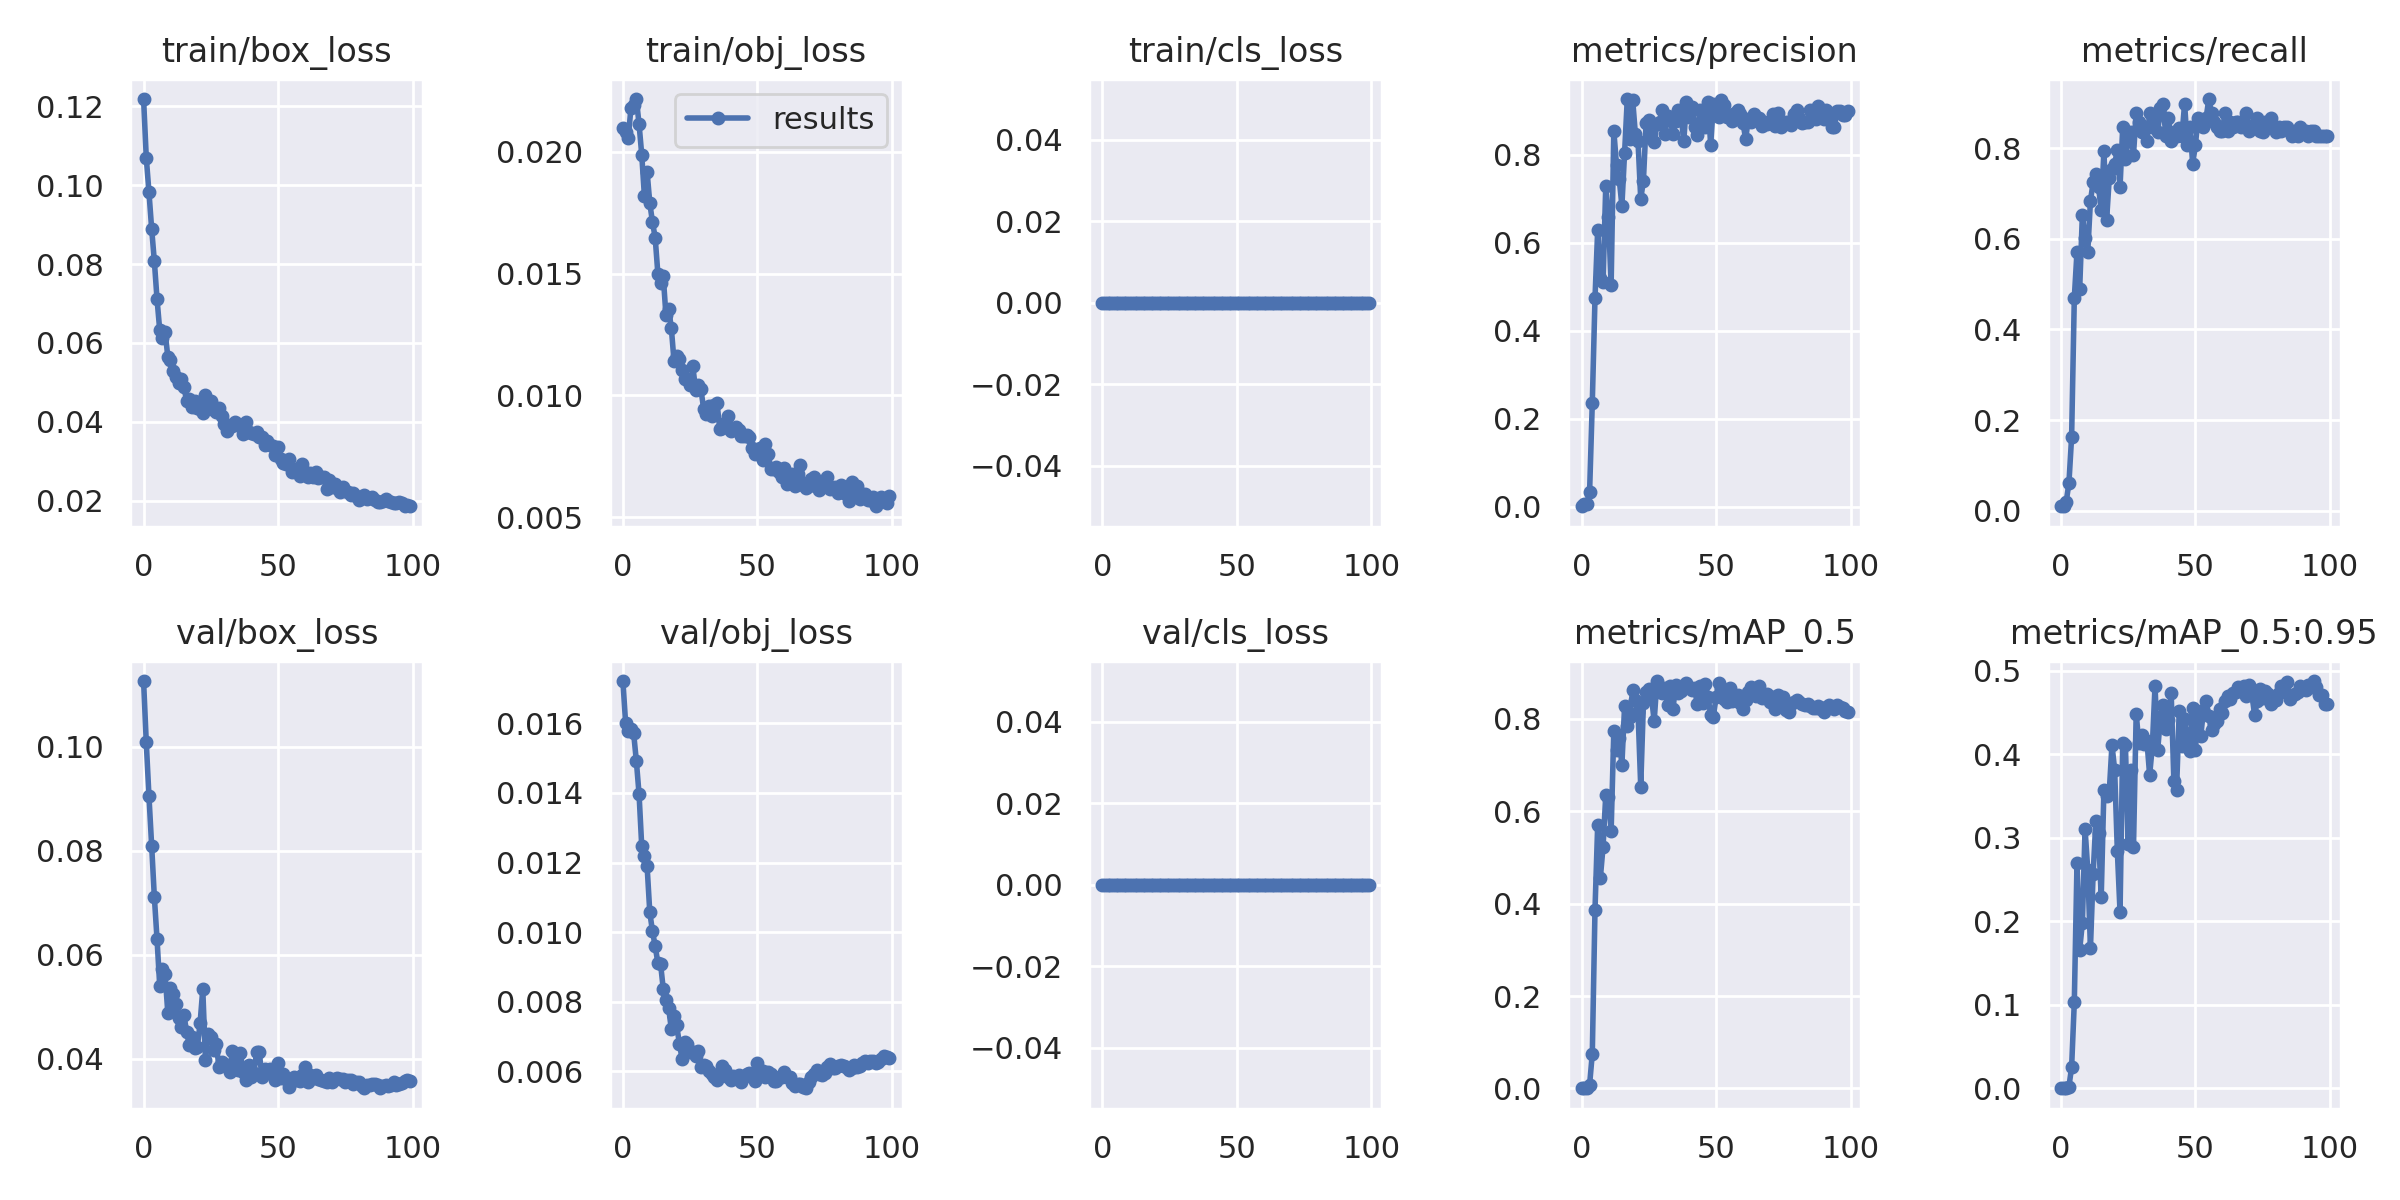

<p>Средняя</p>

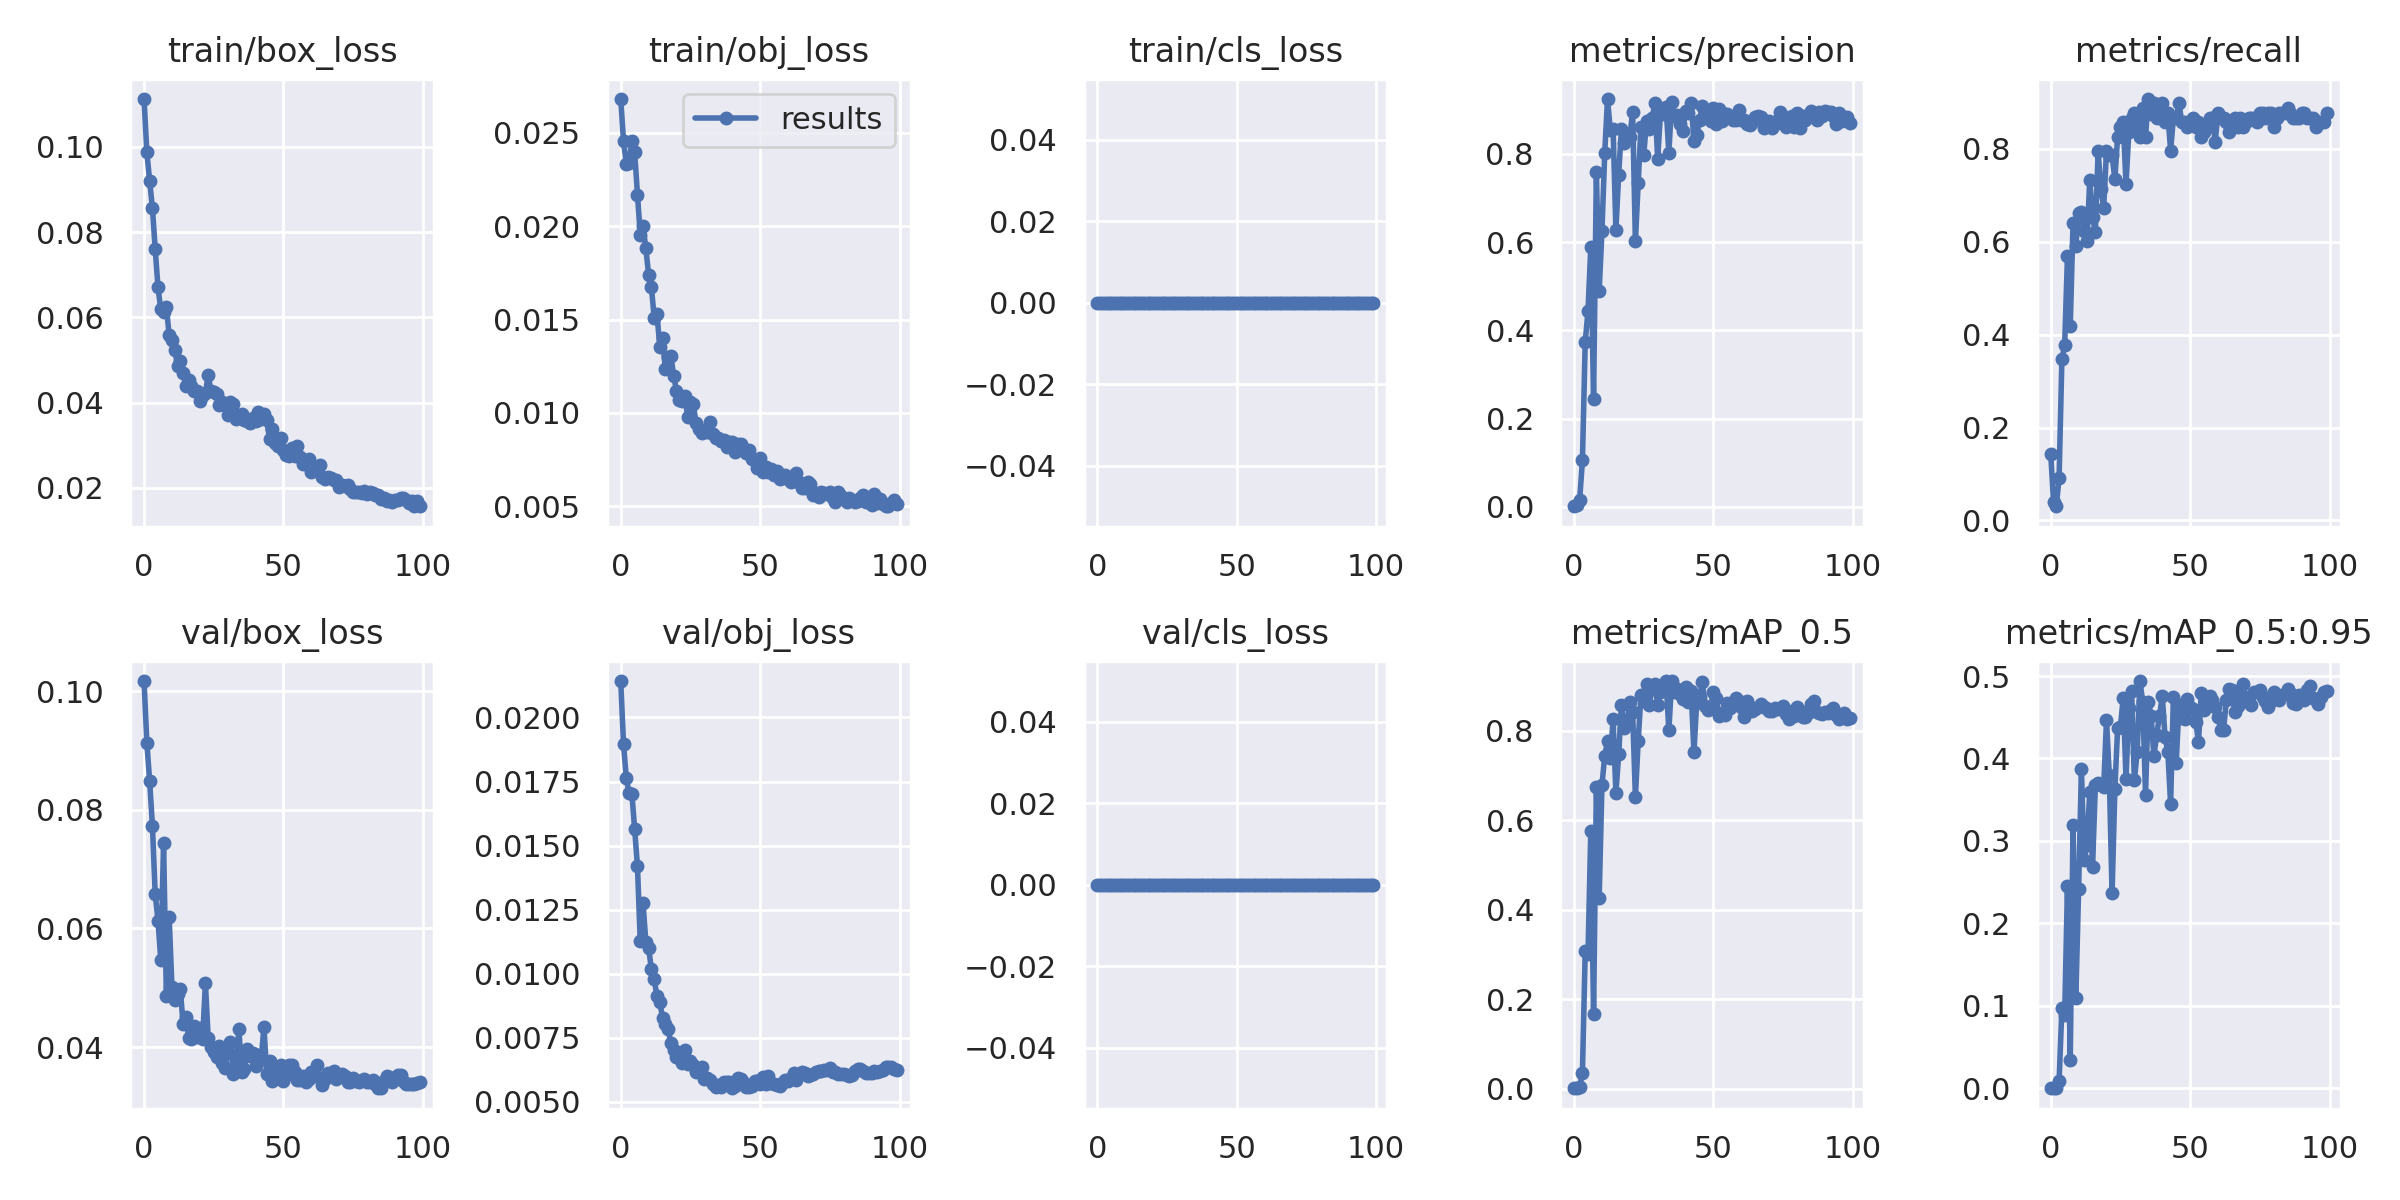

<p><Большая</p>

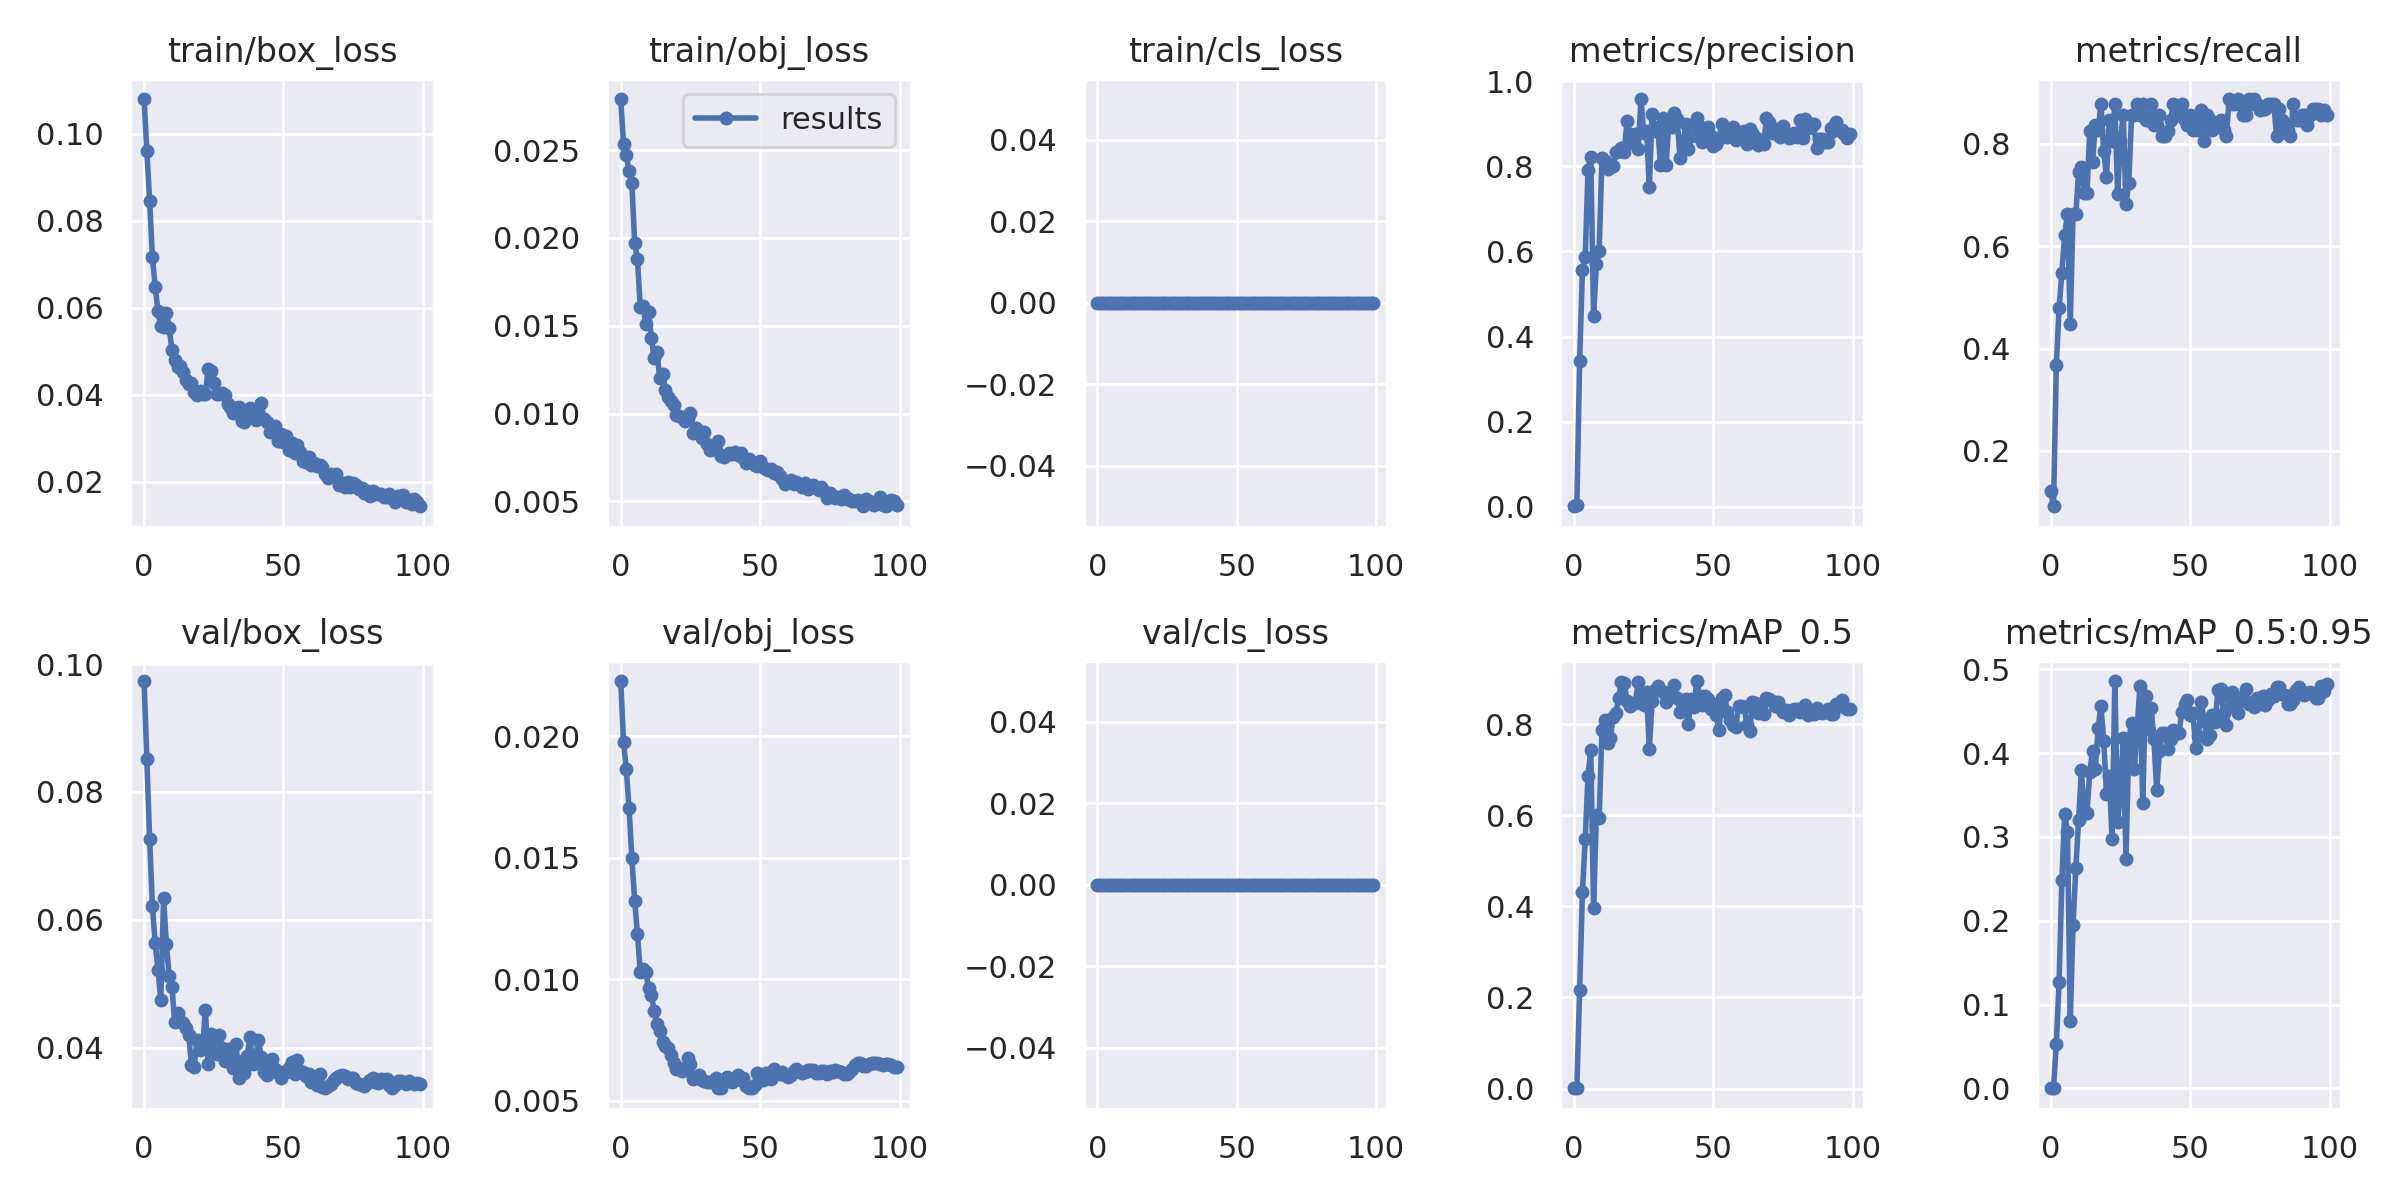

Если будут интересны конкретные цифры, то они могу быть представлены мной дополнительно.



In [17]:
!python train.py --img 640 --batch 16 --epochs 100 --data ./data/licplate.yaml --weights yolov5l.pt

In [17]:
!python detect.py --weights /content/yolov5/gdrive/MyDrive/sber/models/medium.pt --img 640 --conf 0.25 --source /content/yolov5/dataset/val/images --save-crop --nosave

В качестве модели для распознавания была выбрана padlleocr. В целом я просмотрел все sota модели на paperswithcode, но решил остановиться на этой. Ее выбрал исходя из хороших результатов на "чистых" снимках, высокой скорости работы, относительной простоты использования и легкости встраивания в требуемый сервис. Ниже приведены результаты работы на кропах из валидации, полученных после детекции.

[2021/09/12 17:35:14] root WARNING: lang en is not support in PP-OCRv2, use PP-OCR instead
[2021/09/12 17:35:14] root WARNING: lang en is not support in PP-OCRv2, use PP-OCR instead
[2021/09/12 17:35:14] root WARNING: version PP-OCRv2 not support cls models, use version PP-OCR instead
download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_ppocr_mobile_v2.0_det_infer.tar to /root/.paddleocr/2.3.0.1/ocr/det/en/en_ppocr_mobile_v2.0_det_infer/en_ppocr_mobile_v2.0_det_infer.tar


100%|██████████| 3.16M/3.16M [00:02<00:00, 1.39MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/multilingual/en_number_mobile_v2.0_rec_infer.tar to /root/.paddleocr/2.3.0.1/ocr/rec/en/en_number_mobile_v2.0_rec_infer/en_number_mobile_v2.0_rec_infer.tar


100%|██████████| 2.70M/2.70M [00:01<00:00, 1.57MiB/s]


download https://paddleocr.bj.bcebos.com/dygraph_v2.0/ch/ch_ppocr_mobile_v2.0_cls_infer.tar to /root/.paddleocr/2.3.0.1/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer/ch_ppocr_mobile_v2.0_cls_infer.tar


100%|██████████| 1.45M/1.45M [00:01<00:00, 890kiB/s] 


Namespace(benchmark=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir='/root/.paddleocr/2.3.0.1/ocr/cls/ch_ppocr_mobile_v2.0_cls_infer', cls_thresh=0.9, cpu_threads=10, det=True, det_algorithm='DB', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='/root/.paddleocr/2.3.0.1/ocr/det/en/en_ppocr_mobile_v2.0_det_infer', det_sast_nms_thresh=0.2, det_sast_polygon=False, det_sast_score_thresh=0.5, drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_polygon=True, e2e_pgnet_score_thresh=0.5, e2e_pgnet_valid_set='totaltext', enable_mkldnn=False, gpu_mem=500, help='==SUPPRESS==', image_dir=None, ir_optim=True, label_list=['0', '180'], lang='en', layout_path_model='l

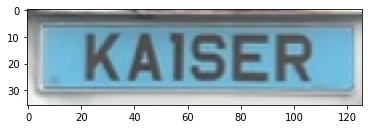

('AxErog', 0.5355582)


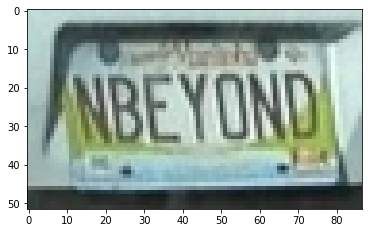

('2', 0.8736135)


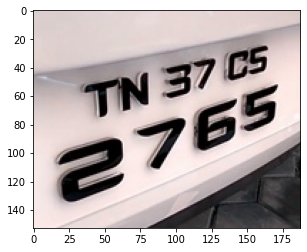

('BL3', 0.6508716)


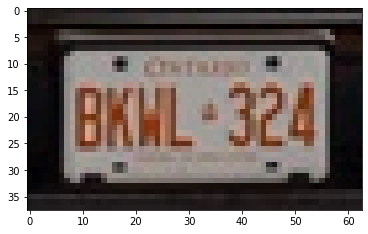

('15-LK-10898', 0.9951475)


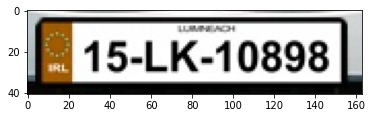

('', nan)


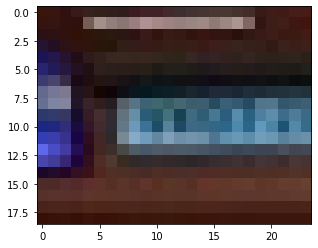

('\\ JA62 UAR', 0.9099757)


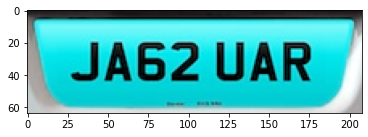

('35215', 0.5251297)


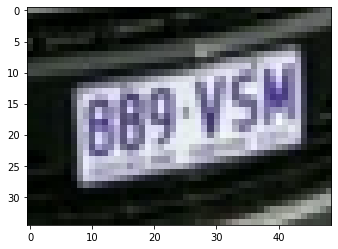

('A', 0.1810495)


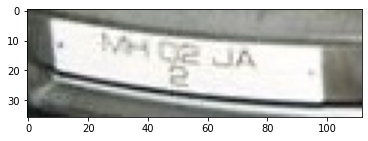

('8NZ1017', 0.7884734)


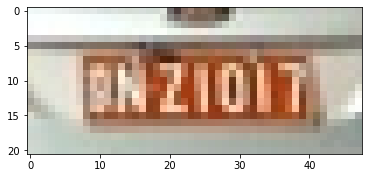

('RX5I0', 0.28156027)


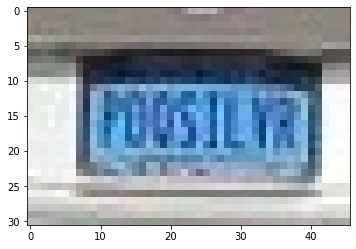

('HANISA', 0.9343664)


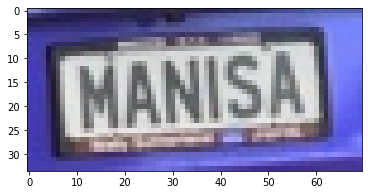

('mm aaraa', 0.42570192)


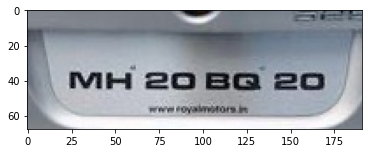

('5505', 0.41174316)


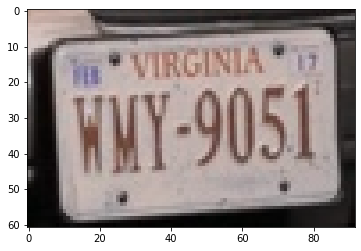

('HHQRe39g', 0.35575378)


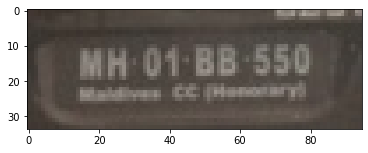

('SHAKREK', 0.82266206)


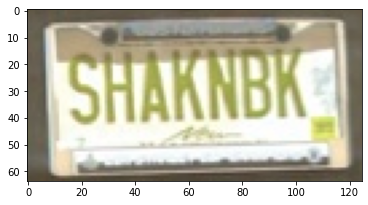

('Gien', 0.60759246)


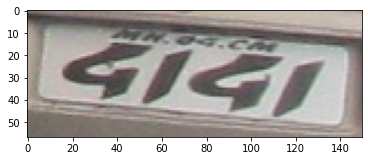

('1268', 0.999702)


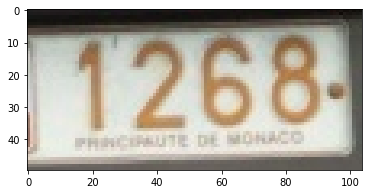

('350', 0.44734398)


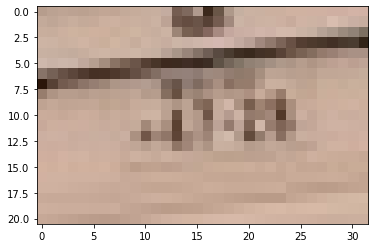

('IPYEGIEXU', 0.81123114)


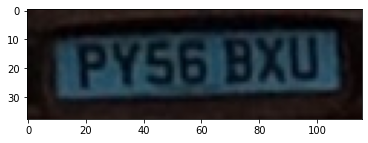

('YD63 LB', 0.8658734)


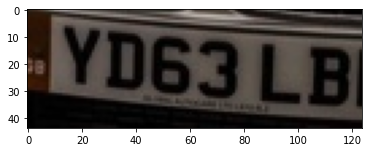

('CN', 0.26514474)


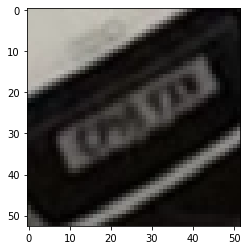

('HR26 AZ 5827', 0.88015336)


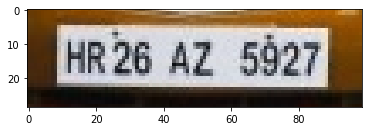

('P', 0.3349044)


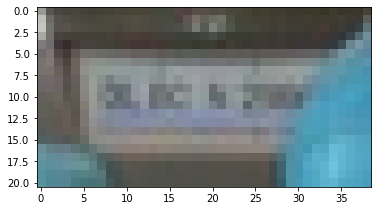

('HHO1AY886G', 0.9266921)


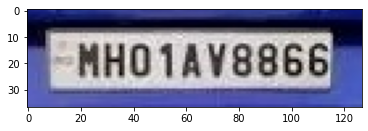

('BAMAR', 0.75939596)


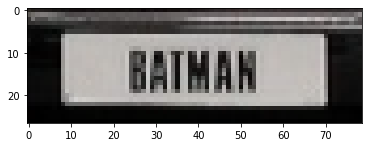

('', nan)


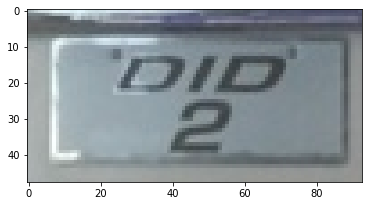

('YD63 LB', 0.8658734)


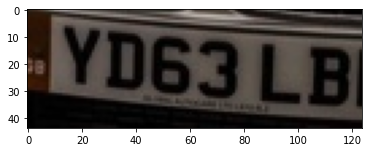

('695299', 0.9374494)


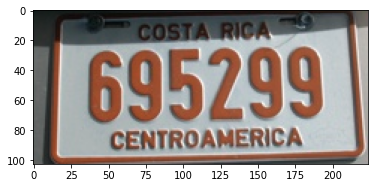

('5995', 0.5080874)


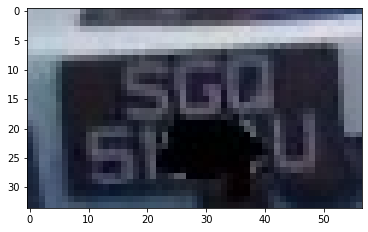

('CHO1ANOOO', 0.9092771)


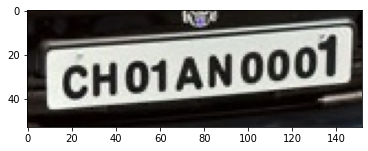

('HTLI', 0.30960912)


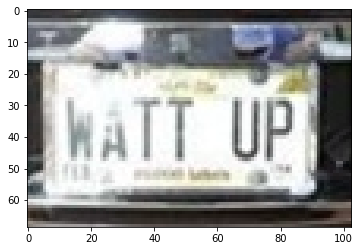

('KA-03-MG-2784', 0.9328499)


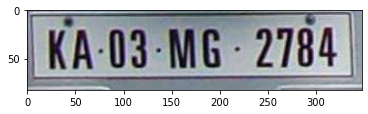

('R25 CU6728', 0.76853985)


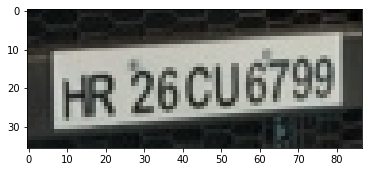

('|MH 12 NE 892z', 0.7972857)


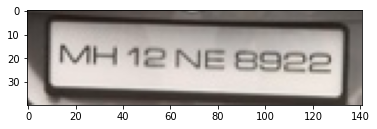

('I0L', 0.41819596)


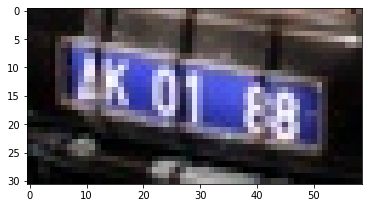

('j fA 03 AB 3380', 0.8585974)


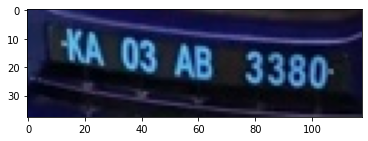

('ALR 486', 0.97296417)


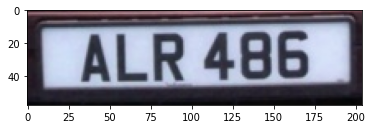

('1', 0.21324214)


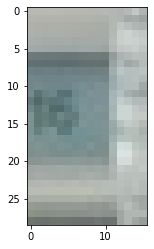

('M', 0.11621496)


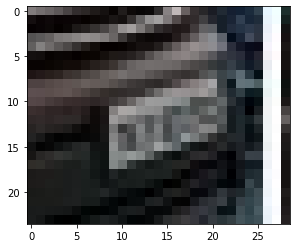

('BO', 0.35464618)


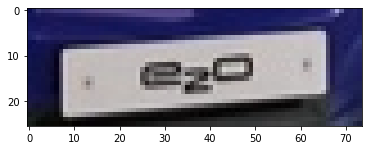

('cor2p0m', 0.6612589)


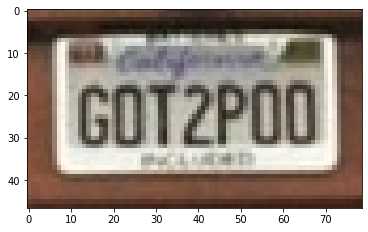

('RE', 0.5708819)


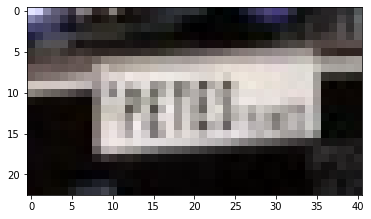

('LAB241887', 0.79035556)


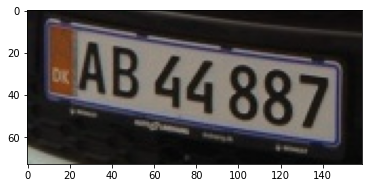

('FGJ03JL0126', 0.9246635)


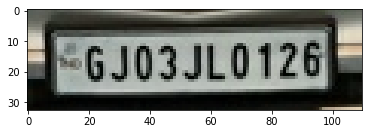

('15-LK-10898', 0.9951475)


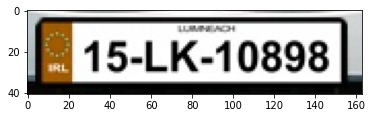

('3', 0.48025927)


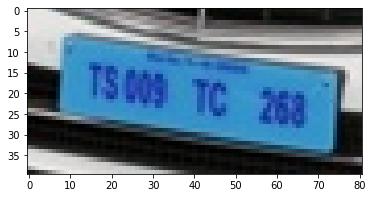

('DL49 AK49', 0.8949382)


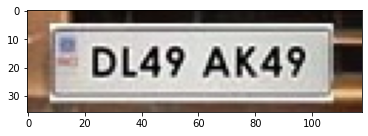

('UP1CTCISce', 0.57495654)


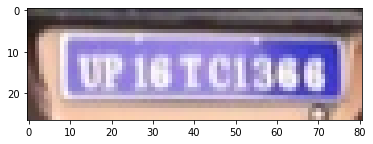

('B2228HM', 0.98196954)


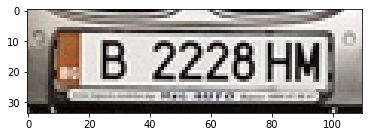

('', nan)


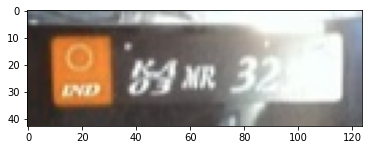

('9', 0.4331491)


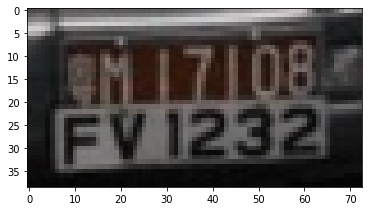

('_[IM4U 555]_', 0.86119795)


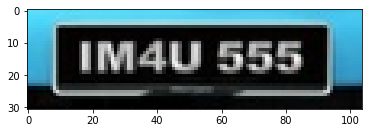

('TIBIEN', 0.29880592)


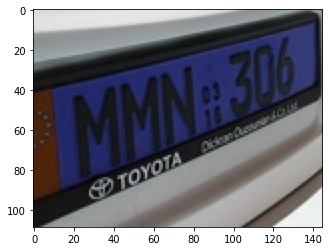

('5', 0.106371455)


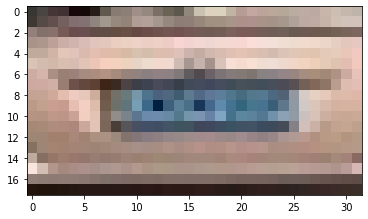

('15-LK-10898', 0.9951475)


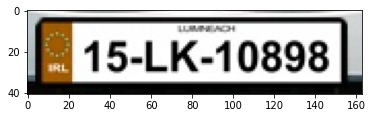

('SGQ5i_JU', 0.8205097)


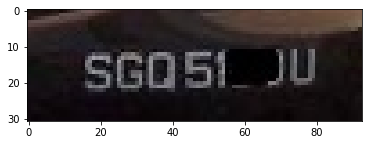

('Imza aR aoxl', 0.50084835)


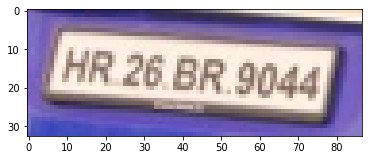

('Imza aR aoxl', 0.50084835)


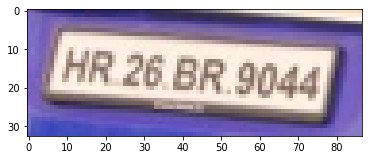

('B', 0.18342295)


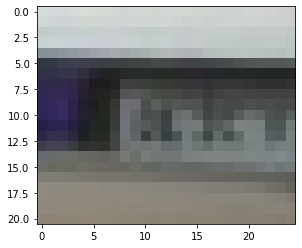

('105', 0.41403803)


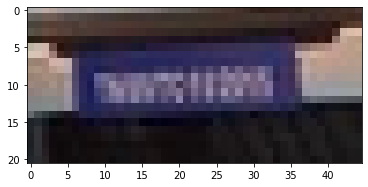

('U3548', 0.6447894)


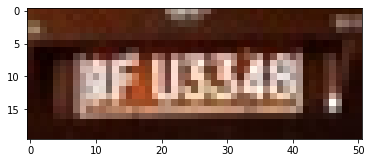

('a', 0.2769367)


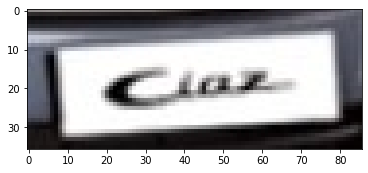

('DETMIE', 0.4799645)


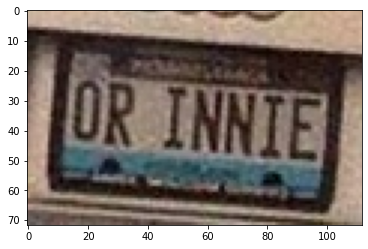

('PG MN112', 0.91916174)


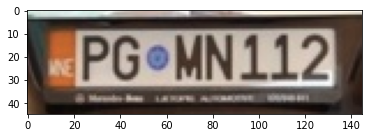

('M', 0.23999737)


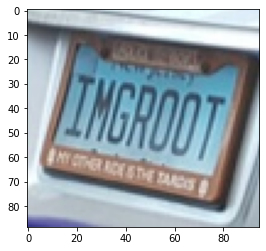

('[ DZl7 YXR', 0.8705579)


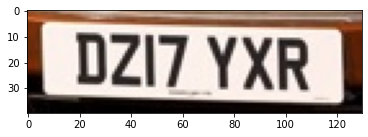

('Bs8EB', 0.28589806)


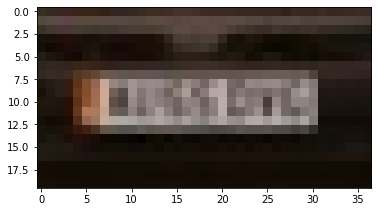

('LR001', 0.39441186)


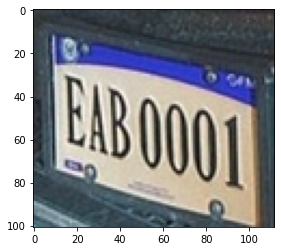

('#DL8cX 4850', 0.9114588)


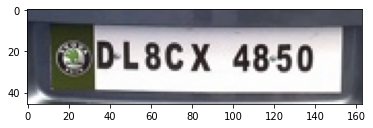

('H02 B82', 0.75683457)


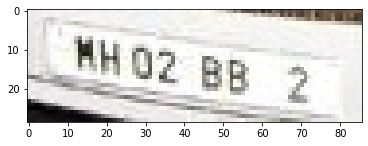

('.NLGOLX', 0.70826375)


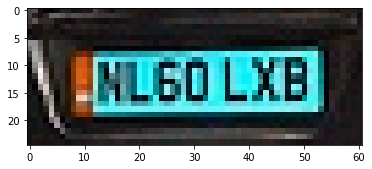

('GCOOGLE', 0.87964064)


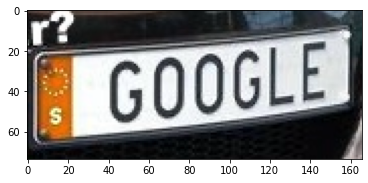

('1', 0.20740859)


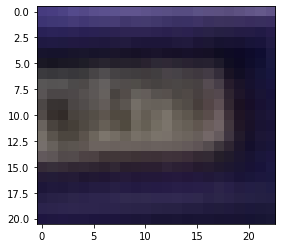

('MH 01 DB 004', 0.8914583)


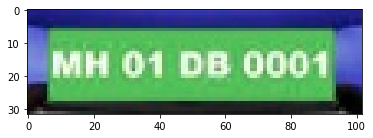

('UP1CTCISce', 0.57495654)


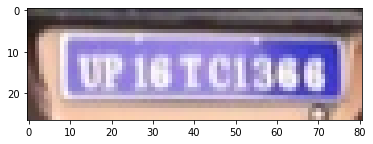

('Re235', 0.39154023)


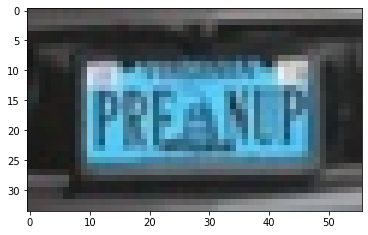

('30221', 0.47225332)


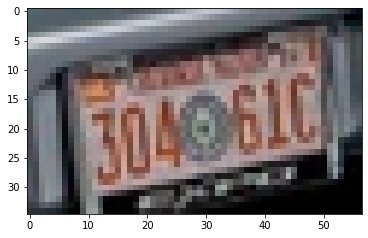

('Cia t2z]', 0.58297396)


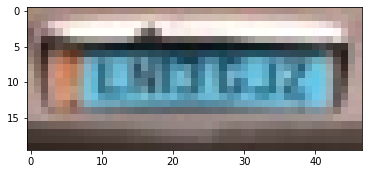

('BL3', 0.6508716)


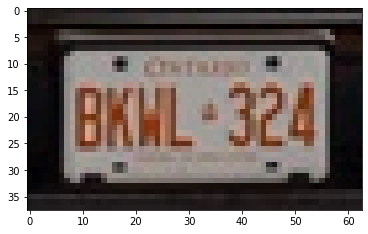

('aas', 0.27304384)


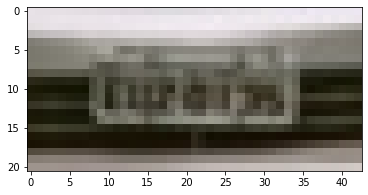

('RNG', 0.3062893)


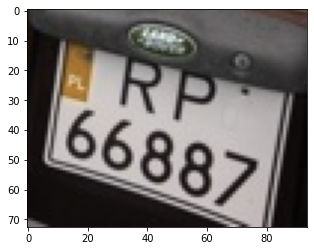

('VUG3CTY', 0.8500018)


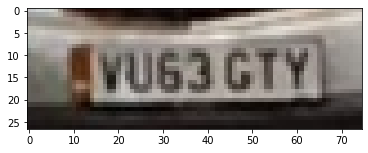

('28', 0.33302203)


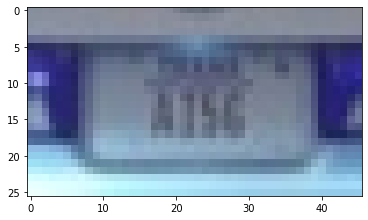

('.LOLLD', 0.51131994)


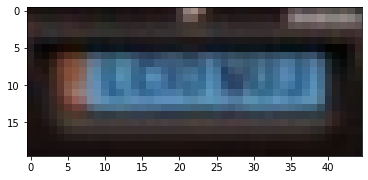

('UMERE', 0.4781641)


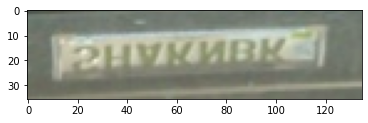

('=', 0.4738668)


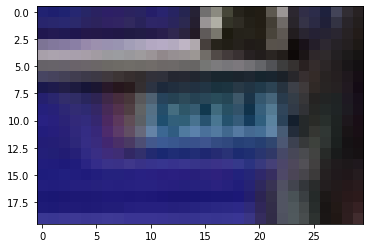

('ViteR', 0.5047277)


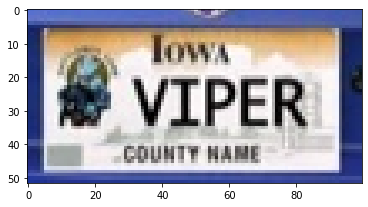

('MH20EE7598', 0.98229885)


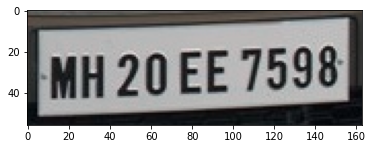

('Tn.65', 0.3475764)


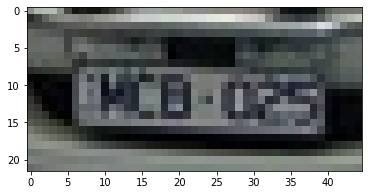

(' G526 JHD', 0.94170785)


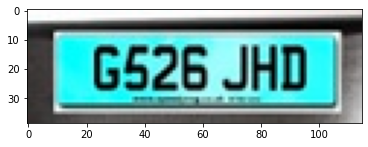

('LAWYER', 0.99715304)


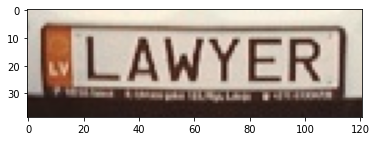

('09', 0.3394875)


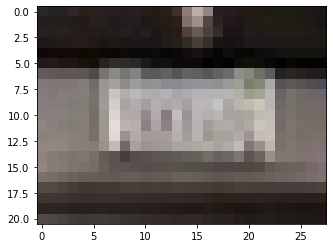

('mm aaraa', 0.42570192)


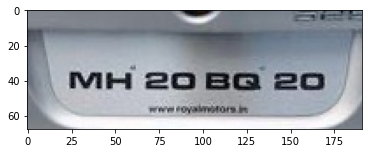

('_K8l7GR ]', 0.8111419)


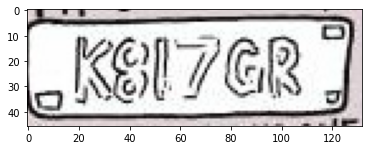

('100201', 0.40426445)


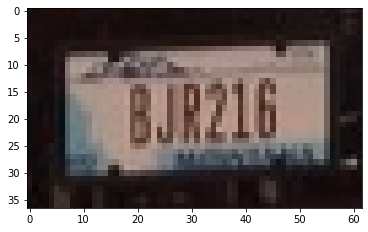

('35215', 0.5251297)


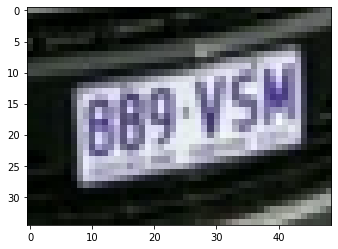

In [15]:
!pip install "paddleocr>=2.0.1"
!pip install paddlepaddle-gpu -i https://mirror.baidu.com/pypi/simple
from paddleocr import PaddleOCR
import cv2
clear_output()


ocr = PaddleOCR(lang='en') 
for img_path in Path('/content/yolov5/runs/detect/exp/crops/lp').glob('*.jpg'):
    result = ocr.ocr(str(img_path), det=False, cls=False)
    for line in result:
        print(line)
    img = cv2.imread(str(img_path))
    plt.imshow(img)
    plt.show()


Я долго думал о том какую метрику можно использовать для оценки качества, в условиях отсутсвия разметки. Пришел к следующим  вариантам:

1.   Распознает ли в целом какой либо текст модель.(Плохо, потому что так не оценивается качество распознования).
2.   Так как картинок мало, то я решил в дополнение к этому вручную отсмотреть дополнительно. Как плюс данного подхода, это может помочь выявить типичные ошибки и/или их причины.



In [17]:
ocr = PaddleOCR(lang='en')
amount = 0
empty = 0 
for img_path in Path('/content/yolov5/runs/detect/exp/crops/lp').glob('*.jpg'):
    result = ocr.ocr(str(img_path), det=False, cls=False)
    ans_len = 0
    for line in result:
        ans_len += len(line[0])
    if ans_len == 0:
        empty += 1
    amount += 1

clear_output()
print(f"Всего = {amount}\nПустых = {empty}")


Всего = 97
Пустых = 3


Таким образом, можно заметить, что практически на всех кропах модель распознает текст, но вот качество распознования сильно зависит от чистоты снимка.


Если говорить о способах улучшения распознования, то можно выделить несколько направлений: 

*   Провести более тщательный анализ и опробовать большое число OCR моделей. 
*   Собрать обучающую выборку и дообучить существующие решения под интересующую нас задачу.
